# How can we figure out the most common color for Final Four teams? 

## Step 1

### We need to combine two sources of data to make this happen: results from tournament games, and team colors. 

In [0]:
from pandas.io import gbq
project_id = '[YOUR_PROJECT_ID]'

import matplotlib.pyplot as plt
import numpy as np

In [4]:
final_four_q = """
SELECT 
  win_market,
  COUNT(win_market) AS appearances,
  colors.color
FROM `bigquery-public-data.ncaa_basketball.mbb_historical_tournament_games` AS teams
LEFT JOIN `bigquery-public-data.ncaa_basketball.team_colors` AS colors ON teams.win_team_id = colors.id
WHERE round = 8
GROUP BY win_market, color
ORDER BY color DESC
"""

final_four = gbq.read_gbq(query=final_four_q, dialect ='standard', project_id=project_id)
final_four.head(10)

Requesting query... ok.
Job ID: job_sr7J1Jhc1f93l7Mev1dkq6xkcep_
Query running...
Query done.
Cache hit.

Retrieving results...
Got 45 rows.

Total time taken 1.11 s.
Finished at 2018-03-08 11:53:24.


,win_market,appearances,color
0,Syracuse,5,#ff5113
1,George Mason,1,#f2aa00
2,Maryland,2,#e31836
3,Illinois,2,#e0322a
4,UNLV,3,#cc092f
5,Utah,1,#c20430
6,Wisconsin,3,#be0f34
7,Ohio State,3,#bb0000
8,Georgia Tech,2,#b09465
9,Oklahoma,3,#a80532


## Step 2

### That's cool, but it doesn't really help us determine which color is the most the common. 

### Let's plot this on a pie chart, using the color codes to color each pie piece. Luckily, similar colors should be somewhat grouped because we ordered by hex color code.

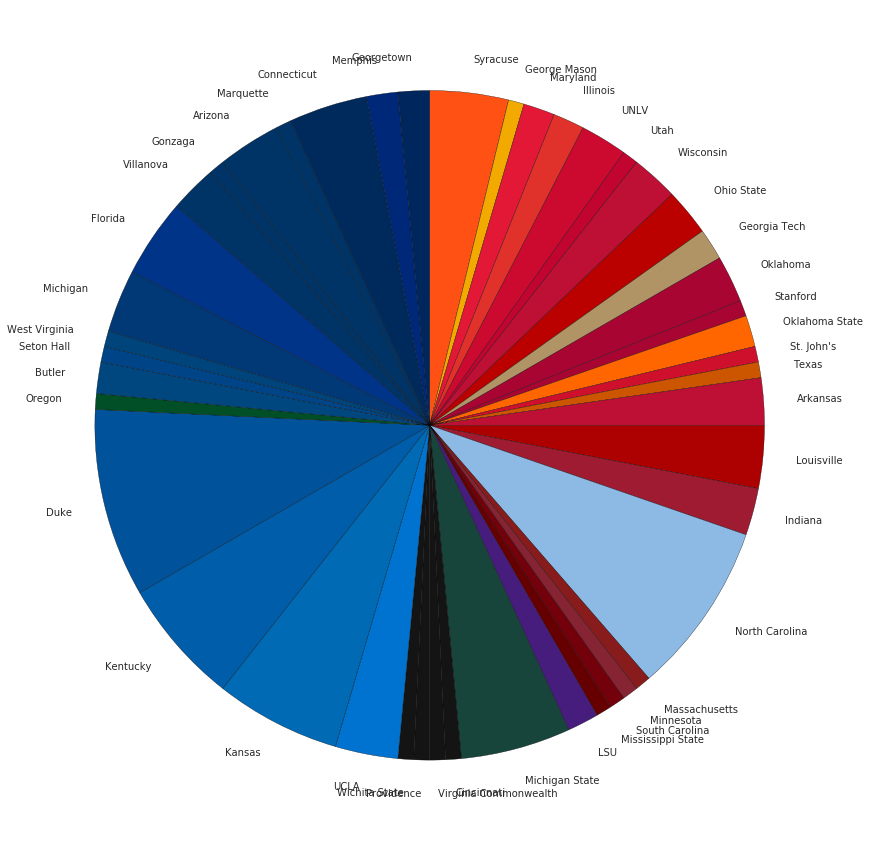

In [5]:
plt.figure(figsize=(15,15))
plt.pie(final_four.appearances, labels=final_four.win_market, colors=final_four.color, startangle=90, counterclock=False);

## Step 3

### It's pretty obvious that the answer is "blue", but the chart isn't yet ordered correctly.

### Hex colors indicate the saturation of red, green, and blue with a 2 digit hexadecimal value for each. So FF0000 is red, 00FF000 is green, and 0000FF is blue.

### Let's arrange the colors on a [color wheel](https://en.wikipedia.org/wiki/Color_wheel). To do this, we'll modify our SQL query so that we group the colors by the most dominant element. As an example, for the reds, we would find the colors where red is most dominant, and then we'll move them toward either green or blue depending on which of those is stronger.

### We'll also start by pulling out the blacks so that they don't end up in the middle of one of the other colors.

In [6]:
final_four2_q = """
SELECT 
  win_market,
  COUNT(win_market) AS appearances,
  color,
  CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) AS red,
  CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) AS green,
  CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) AS blue,
  
  CASE 
       #blacks
       WHEN (CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) = CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) 
       AND CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) = CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
       4000
       #reds  
       WHEN (CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) 
       AND CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
       1000 - CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64)  
       #greens       
       WHEN (CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) 
       AND CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
       2000 - CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)
       #blues       
       WHEN (CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) 
       AND CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64)) THEN 
       3000 - CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64)       
       ELSE NULL
       END AS dominant_color
  
FROM `bigquery-public-data.ncaa_basketball.mbb_historical_tournament_games` AS teams
LEFT JOIN `bigquery-public-data.ncaa_basketball.team_colors` AS colors ON teams.win_team_id = colors.id
WHERE round = 8
GROUP BY win_market, color
ORDER BY dominant_color ASC
"""

final_four2 = gbq.read_gbq(query=final_four2_q, dialect ='standard', project_id=project_id)
final_four2.head(10)

Requesting query... ok.
Job ID: job_7CaVtReAuXKSWP7LLusPeaJ32CHV
Query running...
Query done.
Cache hit.

Retrieving results...
Got 45 rows.

Total time taken 0.89 s.
Finished at 2018-03-08 11:53:53.


,win_market,appearances,color,red,green,blue,dominant_color
0,Oklahoma,3,#a80532,168,5,50,955
1,Stanford,1,#a80532,168,5,50,955
2,Utah,1,#c20430,194,4,48,956
3,UNLV,3,#cc092f,204,9,47,962
4,Arkansas,3,#BE0F34,190,15,52,963
5,Wisconsin,3,#be0f34,190,15,52,963
6,Maryland,2,#e31836,227,24,54,970
7,St. John's,1,#CF102D,207,16,45,971
8,Indiana,3,#9e1b32,158,27,50,977
9,Minnesota,1,#872434,135,36,52,984


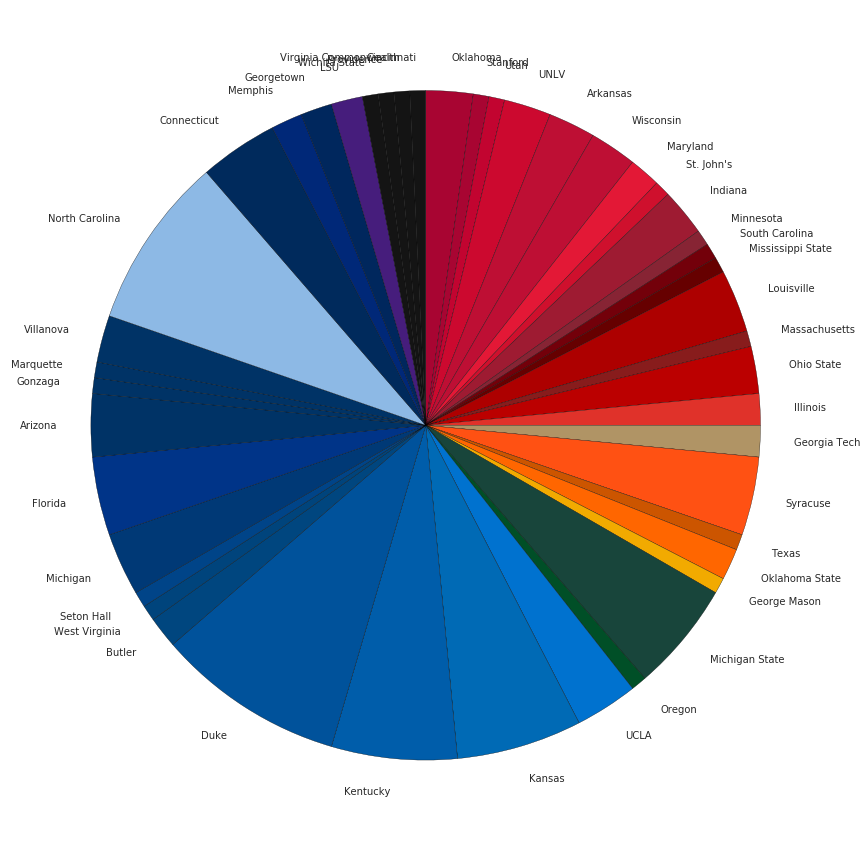

In [7]:
plt.figure(figsize=(15,15))
plt.pie(final_four2.appearances, labels=final_four2.win_market, colors=final_four2.color, startangle=90, counterclock=False);

# "Blue" is now obviously the most common color for Final Four teams!

## Step 4

### What is the exact number? We need a figure out a way to categorize these hex colors using our ordering system. To figure out where the borders between the colors in the rainbow are, let's start by looking at all of the team's colors.

In [8]:
all_colors_q = """
  SELECT 
    colors.market,
    color,
    CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) AS red,
    CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) AS green,
    CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) AS blue,
    CASE 
         #blacks
         WHEN (CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) = CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) 
         AND CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) = CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
         4000
         #reds  
         WHEN (CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) 
         AND CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
         1000 - CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64)  
         #greens       
         WHEN (CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) 
         AND CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
         2000 - CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)
         #blues       
         WHEN (CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) 
         AND CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64)) THEN 
         3000 - CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64)       
         ELSE NULL
         END AS dominant_color

  FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` AS teams
  LEFT JOIN `bigquery-public-data.ncaa_basketball.team_colors` AS colors ON teams.team_id = colors.id
  WHERE division_alias = "D1"
  GROUP BY colors.market, color
  ORDER BY dominant_color ASC
"""

all_colors = gbq.read_gbq(query=all_colors_q, dialect ='standard', project_id=project_id)
all_colors.head(50)

Requesting query... ok.
Job ID: job_hYuIl3sBaobUiKFZ86_pVf5VvKKi
Query running...
Query done.
Processed: 2.4 MB
Standard price: $0.00 USD

Retrieving results...
Got 351 rows.

Total time taken 1.99 s.
Finished at 2018-03-08 11:54:03.


,market,color,red,green,blue,dominant_color
0,Central Michigan,#630237,99,2,55,947
1,Fresno State,#d6083b,214,8,59,949
2,Colgate,#a50334,165,3,52,951
3,Fordham,#a90332,169,3,50,953
4,Lafayette,#98002e,152,0,46,954
5,Elon,#98002e,152,0,46,954
6,Winthrop,#a90533,169,5,51,954
7,Boston College,#98002e,152,0,46,954
8,Alabama A&M,#a41e4c,164,30,76,954
9,Oklahoma,#a80532,168,5,50,955


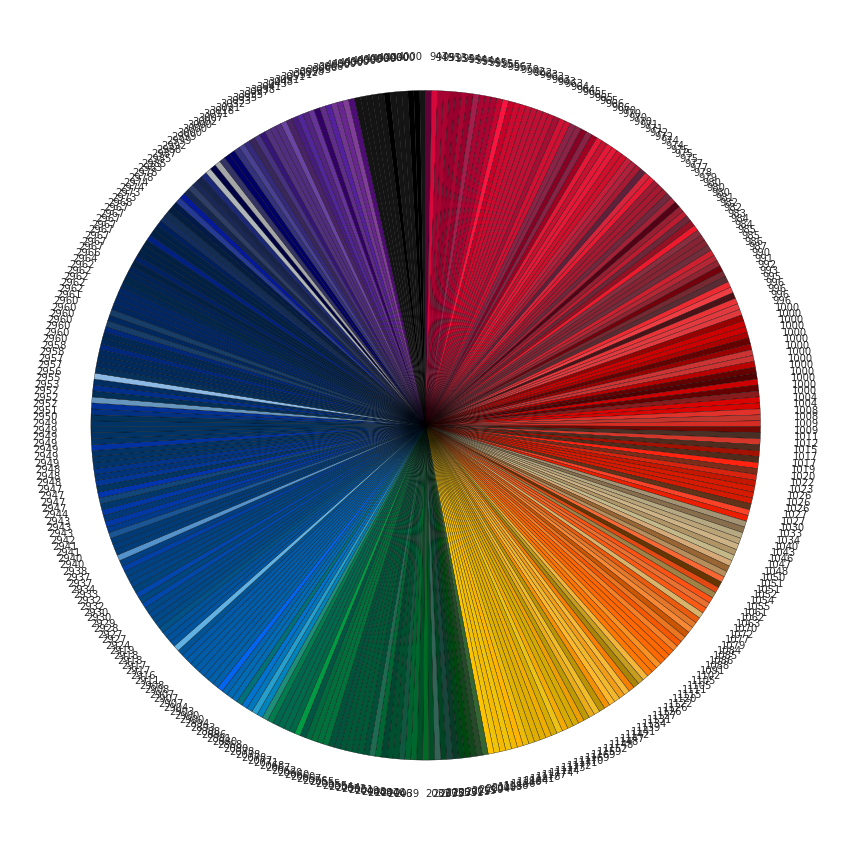

In [9]:
plt.figure(figsize=(15,15))
plt.pie(np.ones(len(all_colors)), colors=all_colors.color, labels=all_colors.dominant_color, startangle=90, counterclock=False);

## Step 4.1

### Well that's nice nice looking, but it's not particularly useful. Let's look at this a different way...

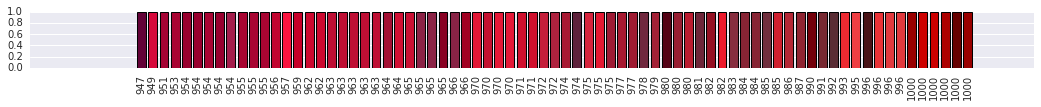

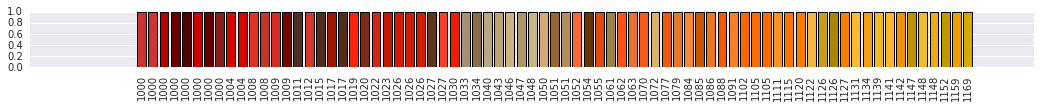

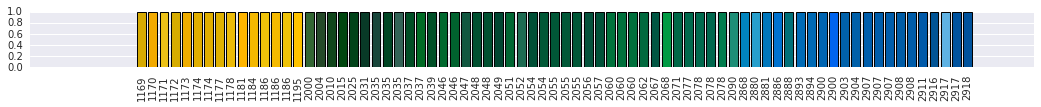

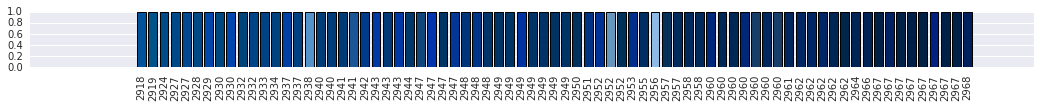

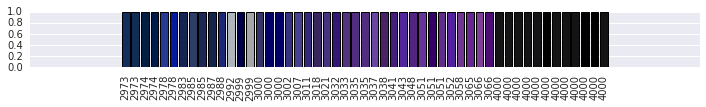

In [10]:
for x, y in zip([0,75,150,225,300], [75,150,225,300,351]):
  plt.figure(figsize=((y-x)/4,1))
  
  x_pos = np.arange(y-x)
  plt.bar(x_pos, np.ones(y-x), color=all_colors.color[x:y], linewidth=1, align="center")
  plt.xticks(x_pos, all_colors.dominant_color[x:y], rotation='vertical')
  plt.show()

## Step 5

### Looking at this chart, we can estimate these the boundaries:

### black >= 3500 > purple >= 3000 > blue >= 2500 > green >= 2000 > yellow >= 1122 > orange >= 1052 > gold >= 1033 > red


In [11]:
all_colors2_q = """

SELECT
  dominant_color,
  COUNT(dominant_color)/351 AS pct
FROM (
  SELECT
    market,
    CASE 
         WHEN dominant_color >= 3500 THEN "black"
         WHEN dominant_color >= 3000 THEN "purple"
         WHEN dominant_color >= 2500 THEN "blue"
         WHEN dominant_color >= 2000 THEN "green"
         WHEN dominant_color >= 1122 THEN "yellow"
         WHEN dominant_color >= 1052 THEN "orange"
         WHEN dominant_color >= 1033 THEN "gold"
         ELSE "red"
         END AS dominant_color
  FROM (
    SELECT 
      colors.market,
      color,
      CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) AS red,
      CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) AS green,
      CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) AS blue,

      CASE 
           #blacks
           WHEN (CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) = CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) 
           AND CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) = CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
           4000
           #reds  
           WHEN (CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) 
           AND CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
           1000 - CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64)  
           #greens       
           WHEN (CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) 
           AND CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
           2000 - CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)
           #blues       
           WHEN (CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) 
           AND CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64)) THEN 
           3000 - CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64)       
           ELSE NULL
           END AS dominant_color

    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` AS teams
    LEFT JOIN `bigquery-public-data.ncaa_basketball.team_colors` AS colors ON teams.team_id = colors.id
    WHERE division_alias = "D1"
    GROUP BY colors.market, color
    ORDER BY dominant_color ASC
  )
)
GROUP BY dominant_color
ORDER BY pct DESC
"""

all_colors2 = gbq.read_gbq(query=all_colors2_q, dialect ='standard', project_id=project_id)
all_colors2.head(50)

Requesting query... ok.
Job ID: job_BQ3V6ZIjhkAK1ix0pBvBPJQvXWVv
Query running...
Query done.
Processed: 2.4 MB
Standard price: $0.00 USD

Retrieving results...
Got 8 rows.

Total time taken 2.05 s.
Finished at 2018-03-08 11:54:20.


,dominant_color,pct
0,blue,0.313390
1,red,0.296296
2,green,0.111111
3,yellow,0.085470
4,purple,0.071225
5,orange,0.059829
6,black,0.034188
7,gold,0.028490


## Step 6

### Using our assumptions for the color boundaries, what is the distribution for Final Four teams?

In [12]:
final_four3_q = """

SELECT
  dominant_color,
  SUM(appearances)/132 AS pct # 33 years of Final Fours = 132 games
FROM (
  SELECT
    appearances,
    CASE 
         WHEN dominant_color >= 3500 THEN "black"
         WHEN dominant_color >= 3000 THEN "purple"
         WHEN dominant_color >= 2500 THEN "blue"
         WHEN dominant_color >= 2000 THEN "green"
         WHEN dominant_color >= 1122 THEN "yellow"
         WHEN dominant_color >= 1052 THEN "orange"
         WHEN dominant_color >= 1033 THEN "gold"
         ELSE "red"
         END AS dominant_color
  FROM (
    SELECT 
      win_market,
      COUNT(win_market) AS appearances,
      color,
      CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) AS red,
      CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) AS green,
      CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) AS blue,

      CASE 
           #blacks
           WHEN (CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) = CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) 
           AND CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) = CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
           4000
           #reds  
           WHEN (CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) 
           AND CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
           1000 - CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64)  
           #greens       
           WHEN (CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) 
           AND CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)) THEN 
           2000 - CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64)
           #blues       
           WHEN (CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64) 
           AND CAST(CONCAT("0x",SUBSTR(color,6,2)) AS INT64) >= CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64)) THEN 
           3000 - CAST(CONCAT("0x",SUBSTR(color,4,2)) AS INT64) + CAST(CONCAT("0x",SUBSTR(color,2,2)) AS INT64)       
           ELSE NULL
           END AS dominant_color

    FROM `bigquery-public-data.ncaa_basketball.mbb_historical_tournament_games` AS teams
    LEFT JOIN `bigquery-public-data.ncaa_basketball.team_colors` AS colors ON teams.win_team_id = colors.id
    WHERE round = 8
    GROUP BY win_market, color
    ORDER BY dominant_color ASC
  )
)
GROUP BY dominant_color
ORDER BY pct DESC
"""

final_four3 = gbq.read_gbq(query=final_four3_q, dialect ='standard', project_id=project_id)
final_four3.head(50)

Requesting query... ok.
Job ID: job_UJP0PQ11tszi319tZUM73swFmU_Q
Query running...
Query done.
Processed: 133.8 KB
Standard price: $0.00 USD

Retrieving results...
Got 8 rows.

Total time taken 1.93 s.
Finished at 2018-03-08 11:54:25.


,dominant_color,pct
0,blue,0.560606
1,red,0.250000
2,orange,0.060606
3,green,0.060606
4,black,0.030303
5,gold,0.015152
6,purple,0.015152
7,yellow,0.007576


## Not only is blue the most dominant color in the Final Four, but it's more than twice as common as the next! 